In [1]:
import os
import re
from pathlib import Path
import polars as pl
from tqdm import tqdm
import pandas as pd  # Just for display purposes if needed

# Configuration
BASE_FOLDER = "/media/onur/Elements/cavity_space_consensus_docking/2025_06_29_batch_dock/consensus_docking_results"
TARGET_FILENAME = "final_results.csv"

print("Libraries imported successfully!")
print(f"Base folder: {BASE_FOLDER}")
print(f"Target filename: {TARGET_FILENAME}")

Libraries imported successfully!
Base folder: /media/onur/Elements/cavity_space_consensus_docking/2025_06_29_batch_dock/consensus_docking_results
Target filename: final_results.csv


In [5]:
def scan_final_results_files(base_folder, target_filename="final_results.csv"):
    """
    Scan for final_results.csv files in subfolders and extract metadata from folder names.
    
    Expected folder format: DB00119_SLC16A2_P36021_cavity_1
    Extracts: DrugBank ID, Gene Name, UniProt ID, Cavity Index
    
    Args:
        base_folder (str): Base directory to search
        target_filename (str): Target CSV filename to find
    
    Returns:
        list: List of dictionaries containing file info and metadata
    """
    files_info = []
    
    # Check if base folder exists
    if not os.path.exists(base_folder):
        print(f"Error: Base folder '{base_folder}' does not exist!")
        return files_info
    
    # Walk through all subdirectories
    for root, dirs, files in tqdm(os.walk(base_folder)):
        if target_filename in files:
            csv_path = os.path.join(root, target_filename)
            
            # Extract folder name from path
            folder_name = os.path.basename(root)
            
            # Parse folder name using regex
            # Pattern: DB\d+_GENENAME_[A-Z0-9]+_cavity_\d+
            pattern = r'^(DB\d+)_([A-Z0-9]+)_([A-Z0-9]+)_cavity_(\d+)$'
            match = re.match(pattern, folder_name)
            
            if match:
                drugbank_id = match.group(1)
                gene_name = match.group(2)
                uniprot_id = match.group(3)
                cavity_index = int(match.group(4))
                
                files_info.append({
                    'csv_path': csv_path,
                    'folder_name': folder_name,
                    'drugbank_id': drugbank_id,
                    'gene_name': gene_name,
                    'uniprot_id': uniprot_id,
                    'cavity_index': cavity_index
                })
            else:
                print(f"Warning: Could not parse folder name '{folder_name}' - skipping")
    
    return files_info

# Scan for files
print("Scanning for final_results.csv files...")
csv_files = scan_final_results_files(BASE_FOLDER, TARGET_FILENAME)

print(f"\nFound {len(csv_files)} final_results.csv files")
if csv_files:
    print("\nFirst 5 files found:")
    for i, file_info in enumerate(csv_files[:5]):
        print(f"{i+1}. {file_info['folder_name']} -> {file_info['drugbank_id']}, {file_info['gene_name']}, {file_info['uniprot_id']}, cavity_{file_info['cavity_index']}")

Scanning for final_results.csv files...


0it [00:00, ?it/s]

9107it [03:46, 65.19it/s] 

18590it [06:46, 107.55it/s]

18603it [06:46, 90.60it/s] 

24594it [07:54, 84.19it/s] 

37234it [10:55, 162.68it/s]

37260it [10:56, 74.62it/s] 

45997it [12:33, 127.08it/s]

47540it [12:55, 74.96it/s] 

48031it [13:05, 27.91it/s] 

63603it [17:30, 28.49it/s] 

70806it [19:25, 60.75it/s] 


Found 5339 final_results.csv files

First 5 files found:
1. DB00908_KCNH1_O95259_cavity_3 -> DB00908, KCNH1, O95259, cavity_3
2. DB01169_PML_O43490_cavity_2 -> DB01169, PML, O43490, cavity_2
3. DB01169_PML_O43490_cavity_5 -> DB01169, PML, O43490, cavity_5
4. DB01173_GRIN3B_O60391_cavity_5 -> DB01173, GRIN3B, O60391, cavity_5
5. DB00598_ADRB2_P07550_cavity_1 -> DB00598, ADRB2, P07550, cavity_1


In [6]:
def load_csv_files_with_metadata(files_info):
    """
    Load all CSV files using Polars and add metadata columns.
    
    Args:
        files_info (list): List of file info dictionaries
    
    Returns:
        pl.DataFrame: Combined dataframe with metadata columns
    """
    if not files_info:
        print("No files to load!")
        return pl.DataFrame()
    
    dataframes = []
    
    print(f"Loading {len(files_info)} CSV files using Polars...")
    
    for file_info in tqdm(files_info, desc="Loading CSV files", unit="file"):
        try:
            # Load CSV with Polars
            df = pl.read_csv(file_info['csv_path'])
            
            # Add metadata columns
            df = df.with_columns([
                pl.lit(file_info['drugbank_id']).alias('drugbank_id'),
                pl.lit(file_info['gene_name']).alias('gene_name'),
                pl.lit(file_info['uniprot_id']).alias('uniprot_id'),
                pl.lit(file_info['cavity_index']).alias('cavity_index'),
                pl.lit(file_info['folder_name']).alias('folder_name'),
                pl.lit(file_info['csv_path']).alias('source_file')
            ])
            
            dataframes.append(df)
            
        except Exception as e:
            print(f"Error loading {file_info['csv_path']}: {e}")
    
    if not dataframes:
        print("No dataframes were successfully loaded!")
        return pl.DataFrame()
    
    # Combine all dataframes
    print("Combining all dataframes...")
    combined_df = pl.concat(dataframes, how="vertical")
    
    return combined_df

# Load all CSV files
if csv_files:
    print("\nStarting to load CSV files...")
    combined_data = load_csv_files_with_metadata(csv_files)
    
    print(f"\nCombined dataset info:")
    print(f"Shape: {combined_data.shape}")
    print(f"Columns: {combined_data.columns}")
    print(f"Memory usage: {combined_data.estimated_size()} bytes")
    
else:
    print("No CSV files found to load!")
    combined_data = pl.DataFrame()


Starting to load CSV files...
Loading 5339 CSV files using Polars...


Loading CSV files: 100%|██████████| 5339/5339 [02:47<00:00, 31.95file/s]



Combining all dataframes...

Combined dataset info:
Shape: (1323415, 15)
Columns: ['Tool1', 'Tool2', 'PoseNumber1', 'PoseNumber2', 'Score1', 'Score2', 'File1', 'File2', 'RMSD', 'drugbank_id', 'gene_name', 'uniprot_id', 'cavity_index', 'folder_name', 'source_file']
Memory usage: 111261916 bytes

Combined dataset info:
Shape: (1323415, 15)
Columns: ['Tool1', 'Tool2', 'PoseNumber1', 'PoseNumber2', 'Score1', 'Score2', 'File1', 'File2', 'RMSD', 'drugbank_id', 'gene_name', 'uniprot_id', 'cavity_index', 'folder_name', 'source_file']
Memory usage: 111261916 bytes


In [7]:
# Display sample data and summary statistics
if not combined_data.is_empty():
    print("=== DATASET SUMMARY ===")
    print(f"Total rows: {combined_data.height:,}")
    print(f"Total columns: {combined_data.width}")
    print(f"Memory usage: {combined_data.estimated_size():,} bytes")
    
    # Show unique counts for metadata columns
    print("\n=== METADATA SUMMARY ===")
    print(f"Unique DrugBank IDs: {combined_data['drugbank_id'].n_unique()}")
    print(f"Unique Gene Names: {combined_data['gene_name'].n_unique()}")
    print(f"Unique UniProt IDs: {combined_data['uniprot_id'].n_unique()}")
    print(f"Unique Cavity Indices: {combined_data['cavity_index'].n_unique()}")
    
    # Show sample of the data
    print("\n=== SAMPLE DATA ===")
    print(combined_data.head())
    
    # Show data types
    print("\n=== DATA TYPES ===")
    print(combined_data.dtypes)
    
else:
    print("No data to display - the combined dataset is empty.")

=== DATASET SUMMARY ===
Total rows: 1,323,415
Total columns: 15
Memory usage: 111,261,916 bytes

=== METADATA SUMMARY ===
Unique DrugBank IDs: 760
Unique Gene Names: 413
Unique UniProt IDs: 413
Unique Cavity Indices: 19

=== SAMPLE DATA ===
shape: (5, 15)
┌───────┬───────┬─────────────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ Tool1 ┆ Tool2 ┆ PoseNumber1 ┆ PoseNumber ┆ … ┆ uniprot_id ┆ cavity_ind ┆ folder_nam ┆ source_fil │
│ ---   ┆ ---   ┆ ---         ┆ 2          ┆   ┆ ---        ┆ ex         ┆ e          ┆ e          │
│ str   ┆ str   ┆ i64         ┆ ---        ┆   ┆ str        ┆ ---        ┆ ---        ┆ ---        │
│       ┆       ┆             ┆ i64        ┆   ┆            ┆ i32        ┆ str        ┆ str        │
╞═══════╪═══════╪═════════════╪════════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ GOLD  ┆ Smina ┆ 1           ┆ 1          ┆ … ┆ O95259     ┆ 3          ┆ DB00908_KC ┆ /media/onu │
│       ┆       ┆             ┆      

In [8]:
# Additional analysis of the dataset
if not combined_data.is_empty():
    print("=== ADDITIONAL ANALYSIS ===")
    
    # Most common DrugBank IDs
    print("\nTop 10 most common DrugBank IDs:")
    drugbank_counts = combined_data.group_by('drugbank_id').agg(pl.count().alias('count')).sort('count', descending=True)
    print(drugbank_counts.head(10))
    
    # Most common Gene Names
    print("\nTop 10 most common Gene Names:")
    gene_counts = combined_data.group_by('gene_name').agg(pl.count().alias('count')).sort('count', descending=True)
    print(gene_counts.head(10))
    
    # Cavity index distribution
    print("\nCavity index distribution:")
    cavity_counts = combined_data.group_by('cavity_index').agg(pl.count().alias('count')).sort('cavity_index')
    print(cavity_counts)
    
    # Show some sample folder names to verify parsing
    print("\nSample folder names (first 10):")
    sample_folders = combined_data.select(['folder_name', 'drugbank_id', 'gene_name', 'uniprot_id', 'cavity_index']).unique().head(10)
    print(sample_folders)

=== ADDITIONAL ANALYSIS ===

Top 10 most common DrugBank IDs:


/tmp/ipykernel_1024784/1810770982.py:7: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  drugbank_counts = combined_data.group_by('drugbank_id').agg(pl.count().alias('count')).sort('count', descending=True)


shape: (10, 2)
┌─────────────┬───────┐
│ drugbank_id ┆ count │
│ ---         ┆ ---   │
│ str         ┆ u32   │
╞═════════════╪═══════╡
│ DB12010     ┆ 32107 │
│ DB00246     ┆ 11620 │
│ DB00726     ┆ 11562 │
│ DB13345     ┆ 11180 │
│ DB01238     ┆ 10894 │
│ DB00734     ┆ 9520  │
│ DB00408     ┆ 9233  │
│ DB01149     ┆ 9200  │
│ DB01136     ┆ 8819  │
│ DB00248     ┆ 8813  │
└─────────────┴───────┘

Top 10 most common Gene Names:
shape: (10, 2)
┌───────────┬───────┐
│ gene_name ┆ count │
│ ---       ┆ ---   │
│ str       ┆ u32   │
╞═══════════╪═══════╡
│ HTR2C     ┆ 94765 │
│ DRD1      ┆ 71622 │
│ HTR2A     ┆ 64156 │
│ AR        ┆ 56039 │
│ ADRB1     ┆ 55706 │
│ ADRA2A    ┆ 55673 │
│ SLC6A4    ┆ 51140 │
│ HTR1A     ┆ 51056 │
│ CHRM3     ┆ 47319 │
│ SLC6A3    ┆ 39201 │
└───────────┴───────┘

Cavity index distribution:


/tmp/ipykernel_1024784/1810770982.py:12: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  gene_counts = combined_data.group_by('gene_name').agg(pl.count().alias('count')).sort('count', descending=True)
/tmp/ipykernel_1024784/1810770982.py:17: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  cavity_counts = combined_data.group_by('cavity_index').agg(pl.count().alias('count')).sort('cavity_index')


shape: (19, 2)
┌──────────────┬────────┐
│ cavity_index ┆ count  │
│ ---          ┆ ---    │
│ i32          ┆ u32    │
╞══════════════╪════════╡
│ 1            ┆ 346626 │
│ 2            ┆ 253957 │
│ 3            ┆ 241533 │
│ 4            ┆ 116504 │
│ 5            ┆ 91121  │
│ …            ┆ …      │
│ 18           ┆ 60     │
│ 19           ┆ 100    │
│ 20           ┆ 285    │
│ 21           ┆ 180    │
│ 22           ┆ 60     │
└──────────────┴────────┘

Sample folder names (first 10):
shape: (10, 5)
┌────────────────────────────────┬─────────────┬───────────┬────────────┬──────────────┐
│ folder_name                    ┆ drugbank_id ┆ gene_name ┆ uniprot_id ┆ cavity_index │
│ ---                            ┆ ---         ┆ ---       ┆ ---        ┆ ---          │
│ str                            ┆ str         ┆ str       ┆ str        ┆ i32          │
╞════════════════════════════════╪═════════════╪═══════════╪════════════╪══════════════╡
│ DB00988_SLC6A4_P31645_cavity_2 ┆ DB00988     ┆ S

In [9]:
# Optional: Save the combined dataset
if not combined_data.is_empty():
    # Save as Parquet for efficient storage (recommended for large datasets)
    output_parquet = "combined_consensus_docking_results.parquet"
    combined_data.write_parquet(output_parquet)
    print(f"Dataset saved as Parquet: {output_parquet}")
    
    # Also save as CSV if needed (might be large)
    output_csv = "combined_consensus_docking_results.csv"
    combined_data.write_csv(output_csv)
    print(f"Dataset saved as CSV: {output_csv}")
    
    # Show file sizes
    import os
    parquet_size = os.path.getsize(output_parquet)
    csv_size = os.path.getsize(output_csv)
    print(f"Parquet file size: {parquet_size:,} bytes ({parquet_size/1024/1024:.1f} MB)")
    print(f"CSV file size: {csv_size:,} bytes ({csv_size/1024/1024:.1f} MB)")
    print(f"Compression ratio: {csv_size/parquet_size:.1f}x smaller with Parquet")
    
else:
    print("No data to save - the combined dataset is empty.")

Dataset saved as Parquet: combined_consensus_docking_results.parquet
Dataset saved as CSV: combined_consensus_docking_results.csv
Parquet file size: 11,289,989 bytes (10.8 MB)
CSV file size: 368,687,394 bytes (351.6 MB)
Compression ratio: 32.7x smaller with Parquet
Dataset saved as CSV: combined_consensus_docking_results.csv
Parquet file size: 11,289,989 bytes (10.8 MB)
CSV file size: 368,687,394 bytes (351.6 MB)
Compression ratio: 32.7x smaller with Parquet


In [2]:
# Optional: Load from saved Parquet file (if you want to skip the scanning/loading process)
load_from_parquet = True  # Set to True if you want to load from saved file

if load_from_parquet:
    parquet_file = "combined_consensus_docking_results.parquet"
    
    if os.path.exists(parquet_file):
        print(f"Loading data from saved Parquet file: {parquet_file}")
        combined_data = pl.read_parquet(parquet_file)
        
        print(f"Loaded dataset info:")
        print(f"Shape: {combined_data.shape}")
        print(f"Columns: {combined_data.columns}")
        print(f"Memory usage: {combined_data.estimated_size():,} bytes")
        
    else:
        print(f"Parquet file '{parquet_file}' not found. Please run the data loading cells first.")
        combined_data = pl.DataFrame()
        
else:
    print("Using data from previous cells (not loading from Parquet).")
    print(f"Current dataset shape: {combined_data.shape if not combined_data.is_empty() else 'Empty'}")

Loading data from saved Parquet file: combined_consensus_docking_results.parquet
Loaded dataset info:
Shape: (1323415, 15)
Columns: ['Tool1', 'Tool2', 'PoseNumber1', 'PoseNumber2', 'Score1', 'Score2', 'File1', 'File2', 'RMSD', 'drugbank_id', 'gene_name', 'uniprot_id', 'cavity_index', 'folder_name', 'source_file']
Memory usage: 362,073,177 bytes
Loaded dataset info:
Shape: (1323415, 15)
Columns: ['Tool1', 'Tool2', 'PoseNumber1', 'PoseNumber2', 'Score1', 'Score2', 'File1', 'File2', 'RMSD', 'drugbank_id', 'gene_name', 'uniprot_id', 'cavity_index', 'folder_name', 'source_file']
Memory usage: 362,073,177 bytes


# Analysis Questions

Now that we have loaded and combined all the consensus docking results, let's ask some important questions about the data:

## Question 1: Drug-UniProt Combinations with Good RMSD Values

**For how many unique drug-uniprot combinations did we observe at least one RMSD value that is below 2.0?**

This will help us understand how many drug-target pairs showed good binding pose predictions (RMSD < 2.0 is generally considered a good docking result).

**Note:** The analysis now includes scoring cutoffs based on the Tool1/Tool2 and Score1/Score2 columns:
- Gold: minimum score of 70 (higher is better)
- Smina: maximum score of -7 (lower is better)  
- LeDock: maximum score of -5 (lower is better)

Only poses that meet these scoring criteria for their respective docking tool will be included in the RMSD analysis.

In [13]:
# Question 1: Drug-UniProt combinations with RMSD < 2.0 (with scoring cutoffs)

# Define scoring cutoffs - adjust these values as needed
GOLD_MIN_SCORE = 70      # Gold: minimum score (higher is better)
SMINA_MAX_SCORE = -7     # Smina: maximum score (lower is better)
LEDOCK_MAX_SCORE = -5    # LeDock: maximum score (lower is better)

if not combined_data.is_empty():
    print("=== ANALYZING RMSD VALUES WITH SCORING CUTOFFS ===")
    print(f"Scoring cutoffs applied:")
    print(f"  Gold minimum score: {GOLD_MIN_SCORE}")
    print(f"  Smina maximum score: {SMINA_MAX_SCORE}")
    print(f"  LeDock maximum score: {LEDOCK_MAX_SCORE}")
    
    # First, let's explore what columns we have that might contain RMSD values and scores
    print("\nAvailable columns:")
    print(combined_data.columns)
    
    # Look for RMSD-related columns
    rmsd_columns = [col for col in combined_data.columns if 'rmsd' in col.lower() or 'RMSD' in col]
    print(f"\nRMSD-related columns found: {rmsd_columns}")
    
    # Look for Tool and Score columns
    tool_columns = [col for col in combined_data.columns if 'tool' in col.lower()]
    score_columns = [col for col in combined_data.columns if 'score' in col.lower()]
    
    print(f"Tool-related columns: {tool_columns}")
    print(f"Score-related columns: {score_columns}")
    
    if rmsd_columns:
        # Use the first RMSD column found
        rmsd_col = rmsd_columns[0]
        print(f"\nUsing column '{rmsd_col}' for RMSD analysis")
        
        # Apply scoring filters based on Tool1/Tool2 and Score1/Score2 columns
        print(f"\nApplying scoring cutoffs...")
        filtered_data = combined_data.clone()
        original_count = filtered_data.height
        
        # Check if we have Tool1/Tool2 and Score1/Score2 columns
        has_tool1 = 'Tool1' in combined_data.columns
        has_tool2 = 'Tool2' in combined_data.columns
        has_score1 = 'Score1' in combined_data.columns
        has_score2 = 'Score2' in combined_data.columns
        
        if has_tool1 and has_score1:
            print("Found Tool1 and Score1 columns")
        if has_tool2 and has_score2:
            print("Found Tool2 and Score2 columns")
        
        # Apply filters based on Tool1/Score1 combination
        if has_tool1 and has_score1:
            before_count = filtered_data.height
            
            # Create separate filter conditions for each tool type
            # For Gold: keep rows where Tool1 is GOLD and Score1 >= threshold
            gold_filter = (pl.col('Tool1').str.to_uppercase() == 'GOLD') & (pl.col('Score1') >= GOLD_MIN_SCORE)
            
            # For Smina: keep rows where Tool1 is SMINA and Score1 <= threshold  
            smina_filter = (pl.col('Tool1').str.to_uppercase() == 'SMINA') & (pl.col('Score1') <= SMINA_MAX_SCORE)
            
            # For LeDock: keep rows where Tool1 contains LEDOCK and Score1 <= threshold
            ledock_filter = (pl.col('Tool1').str.to_uppercase().str.contains('LEDOCK')) & (pl.col('Score1') <= LEDOCK_MAX_SCORE)
            
            # Apply combined filter: keep rows that meet the criteria for their respective tool
            filtered_data = filtered_data.filter(gold_filter | smina_filter | ledock_filter)
            after_count = filtered_data.height
            print(f"Tool1/Score1 filter: {before_count:,} -> {after_count:,} rows (removed {before_count - after_count:,})")
        
        # Apply filters based on Tool2/Score2 combination (if exists)
        if has_tool2 and has_score2:
            before_count = filtered_data.height
            
            # Create separate filter conditions for each tool type
            # For Gold: keep rows where Tool2 is GOLD and Score2 >= threshold
            gold_filter = (pl.col('Tool2').str.to_uppercase() == 'GOLD') & (pl.col('Score2') >= GOLD_MIN_SCORE)
            
            # For Smina: keep rows where Tool2 is SMINA and Score2 <= threshold
            smina_filter = (pl.col('Tool2').str.to_uppercase() == 'SMINA') & (pl.col('Score2') <= SMINA_MAX_SCORE)
            
            # For LeDock: keep rows where Tool2 contains LEDOCK and Score2 <= threshold
            ledock_filter = (pl.col('Tool2').str.to_uppercase().str.contains('LEDOCK')) & (pl.col('Score2') <= LEDOCK_MAX_SCORE)
            
            # Apply combined filter: keep rows that meet the criteria for their respective tool
            filtered_data = filtered_data.filter(gold_filter | smina_filter | ledock_filter)
            after_count = filtered_data.height
            print(f"Tool2/Score2 filter: {before_count:,} -> {after_count:,} rows (removed {before_count - after_count:,})")
        
        # Show breakdown of filtering by tool type
        if has_tool1 and has_score1:
            print(f"\nFiltering breakdown by tool type (after all filters):")
            tool_breakdown = filtered_data.group_by('Tool1').agg([
                pl.count().alias('count'),
                pl.col('Score1').min().alias('min_score'),
                pl.col('Score1').max().alias('max_score'),
                pl.col('Score1').mean().alias('mean_score')
            ]).sort('count', descending=True)
            print("Tool1 breakdown:")
            print(tool_breakdown)
            
        if has_tool2 and has_score2:
            tool2_breakdown = filtered_data.group_by('Tool2').agg([
                pl.count().alias('count'),
                pl.col('Score2').min().alias('min_score'),
                pl.col('Score2').max().alias('max_score'),
                pl.col('Score2').mean().alias('mean_score')
            ]).sort('count', descending=True)
            print("\nTool2 breakdown:")
            print(tool2_breakdown)
        
        final_count = filtered_data.height
        print(f"\nTotal filtering effect: {original_count:,} -> {final_count:,} rows")
        print(f"Retained {(final_count / original_count) * 100:.1f}% of original data")
        
        if final_count == 0:
            print("WARNING: No data remains after applying filters. Consider relaxing the cutoffs.")
        else:
            
            # Show sample of Tool/Score combinations in filtered data
            print(f"\nSample Tool/Score combinations in filtered data:")
            if has_tool1 and has_score1:
                sample_tools = filtered_data.select(['Tool1', 'Score1']).head(10)
                print("Tool1/Score1 samples:")
                print(sample_tools)
            
            if has_tool2 and has_score2:
                sample_tools2 = filtered_data.select(['Tool2', 'Score2']).head(10)
                print("\nTool2/Score2 samples:")
                print(sample_tools2)

            # Check data types and sample values
            print(f"\nData type of {rmsd_col}: {filtered_data[rmsd_col].dtype}")
            print(f"Sample values from filtered data:")
            print(filtered_data.select([rmsd_col]).head(10))
            
            # Basic statistics of RMSD values (filtered data)
            rmsd_stats = filtered_data.select([
                pl.col(rmsd_col).count().alias('total_count'),
                pl.col(rmsd_col).min().alias('min_rmsd'),
                pl.col(rmsd_col).max().alias('max_rmsd'),
                pl.col(rmsd_col).mean().alias('mean_rmsd'),
                pl.col(rmsd_col).median().alias('median_rmsd'),
                pl.col(rmsd_col).std().alias('std_rmsd')
            ])
            
            print(f"\nRMSD Statistics (filtered data):")
            print(rmsd_stats)
            
            # Filter for RMSD < 2.0 within the already filtered data
            good_rmsd_data = filtered_data.filter(pl.col(rmsd_col) < 2.0)
            
            print(f"\nRows with RMSD < 2.0 (after score filtering): {good_rmsd_data.height:,} out of {filtered_data.height:,} filtered rows")
            print(f"Percentage with good RMSD (within filtered data): {(good_rmsd_data.height / filtered_data.height) * 100:.1f}%")
            
            # Count unique drug-uniprot combinations with RMSD < 2.0
            unique_combinations_good_rmsd = good_rmsd_data.select(['drugbank_id', 'uniprot_id']).unique()
            
            print(f"\n=== ANSWER TO QUESTION 1 (WITH SCORING FILTERS) ===")
            print(f"Number of unique drug-uniprot combinations with at least one RMSD < 2.0 (meeting score criteria): {unique_combinations_good_rmsd.height:,}")
            
            # Also show total unique combinations for comparison (within filtered data)
            total_unique_combinations_filtered = filtered_data.select(['drugbank_id', 'uniprot_id']).unique()
            print(f"Total unique drug-uniprot combinations (meeting score criteria): {total_unique_combinations_filtered.height:,}")
            print(f"Percentage of filtered combinations with good RMSD: {(unique_combinations_good_rmsd.height / total_unique_combinations_filtered.height) * 100:.1f}%")
            
            # Compare with unfiltered results
            total_unique_combinations_all = combined_data.select(['drugbank_id', 'uniprot_id']).unique()
            print(f"\nComparison with unfiltered data:")
            print(f"Total combinations (all data): {total_unique_combinations_all.height:,}")
            print(f"Total combinations (filtered): {total_unique_combinations_filtered.height:,}")
            print(f"Filtering retained {(total_unique_combinations_filtered.height / total_unique_combinations_all.height) * 100:.1f}% of combinations")
            
            # Show some examples of good combinations
            print(f"\nSample drug-uniprot combinations with RMSD < 2.0 (meeting score criteria):")
            sample_good_combinations = good_rmsd_data.select(['drugbank_id', 'uniprot_id', 'gene_name', rmsd_col]).unique().head(10)
            print(sample_good_combinations)
            
            # Store filtered data for use in subsequent cells
            globals()['filtered_data'] = filtered_data
        
    else:
        print("No RMSD-related columns found in the dataset.")
        print("Please check the column names and ensure RMSD data is available.")
        
else:
    print("No data available for analysis. Please load the dataset first.")

=== ANALYZING RMSD VALUES WITH SCORING CUTOFFS ===
Scoring cutoffs applied:
  Gold minimum score: 70
  Smina maximum score: -7
  LeDock maximum score: -5

Available columns:
['Tool1', 'Tool2', 'PoseNumber1', 'PoseNumber2', 'Score1', 'Score2', 'File1', 'File2', 'RMSD', 'drugbank_id', 'gene_name', 'uniprot_id', 'cavity_index', 'folder_name', 'source_file']

RMSD-related columns found: ['RMSD']
Tool-related columns: ['Tool1', 'Tool2']
Score-related columns: ['Score1', 'Score2']

Using column 'RMSD' for RMSD analysis

Applying scoring cutoffs...
Found Tool1 and Score1 columns
Found Tool2 and Score2 columns
Tool1/Score1 filter: 1,323,415 -> 51,301 rows (removed 1,272,114)
Tool2/Score2 filter: 51,301 -> 35,342 rows (removed 15,959)

Filtering breakdown by tool type (after all filters):
Tool1 breakdown:
shape: (2, 5)
┌────────┬───────┬───────────┬───────────┬────────────┐
│ Tool1  ┆ count ┆ min_score ┆ max_score ┆ mean_score │
│ ---    ┆ ---   ┆ ---       ┆ ---       ┆ ---        │
│ str    ┆

/tmp/ipykernel_1174119/223127388.py:93: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('count'),
/tmp/ipykernel_1174119/223127388.py:103: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('count'),



Comparison with unfiltered data:
Total combinations (all data): 2,035
Total combinations (filtered): 294
Filtering retained 14.4% of combinations

Sample drug-uniprot combinations with RMSD < 2.0 (meeting score criteria):
shape: (10, 4)
┌─────────────┬────────────┬───────────┬──────────┐
│ drugbank_id ┆ uniprot_id ┆ gene_name ┆ RMSD     │
│ ---         ┆ ---        ┆ ---       ┆ ---      │
│ str         ┆ str        ┆ str       ┆ f64      │
╞═════════════╪════════════╪═══════════╪══════════╡
│ DB08815     ┆ P08913     ┆ ADRA2A    ┆ 1.879608 │
│ DB00834     ┆ P10275     ┆ AR        ┆ 1.405664 │
│ DB00834     ┆ P10275     ┆ AR        ┆ 1.62317  │
│ DB08815     ┆ P08913     ┆ ADRA2A    ┆ 1.923856 │
│ DB08941     ┆ P07550     ┆ ADRB2     ┆ 1.921243 │
│ DB08941     ┆ P07550     ┆ ADRB2     ┆ 1.667793 │
│ DB00434     ┆ P20309     ┆ CHRM3     ┆ 0.167948 │
│ DB00434     ┆ P20309     ┆ CHRM3     ┆ 0.158473 │
│ DB00434     ┆ P20309     ┆ CHRM3     ┆ 0.143618 │
│ DB00834     ┆ P10275     ┆ AR   

In [14]:
# Additional RMSD Analysis - Distribution and Thresholds (with scoring cutoffs)

if not combined_data.is_empty() and rmsd_columns and 'filtered_data' in globals():
    rmsd_col = rmsd_columns[0]
    
    print("=== RMSD DISTRIBUTION ANALYSIS (FILTERED DATA) ===")
    
    # Use filtered data instead of combined_data
    analysis_data = filtered_data
    
    # Analyze different RMSD thresholds
    thresholds = [1.0, 1.5, 2.0, 2.5, 3.0]
    
    print("RMSD Threshold Analysis (filtered data):")
    print("Threshold | Rows with RMSD < threshold | Unique Drug-UniProt Combinations")
    print("-" * 75)
    
    for threshold in thresholds:
        # Count rows below threshold
        rows_below = analysis_data.filter(pl.col(rmsd_col) < threshold).height
        
        # Count unique combinations below threshold
        unique_below = analysis_data.filter(pl.col(rmsd_col) < threshold).select(['drugbank_id', 'uniprot_id']).unique().height
        
        print(f"{threshold:>9.1f} | {rows_below:>25,} | {unique_below:>30,}")
    
    # Distribution bins
    print(f"\nRMSD Distribution (bins) - filtered data:")
    bins = [0, 1, 2, 3, 4, 5, 10, float('inf')]
    bin_labels = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-10', '10+']
    
    for i, (lower, upper) in enumerate(zip(bins[:-1], bins[1:])):
        if upper == float('inf'):
            count = analysis_data.filter(pl.col(rmsd_col) >= lower).height
        else:
            count = analysis_data.filter((pl.col(rmsd_col) >= lower) & (pl.col(rmsd_col) < upper)).height
        
        percentage = (count / analysis_data.height) * 100
        print(f"RMSD {bin_labels[i]:>5}: {count:>8,} rows ({percentage:>5.1f}%)")
    
    # Best performing drug-uniprot combinations (from filtered data)
    print(f"\n=== TOP 10 BEST PERFORMING COMBINATIONS (lowest RMSD, meeting score criteria) ===")
    best_combinations = analysis_data.group_by(['drugbank_id', 'uniprot_id', 'gene_name']).agg(
        pl.col(rmsd_col).min().alias('best_rmsd'),
        pl.col(rmsd_col).count().alias('total_poses')
    ).sort('best_rmsd').head(10)
    
    print(best_combinations)
    
    # Comparison with unfiltered data
    print(f"\n=== COMPARISON: FILTERED vs UNFILTERED DATA ===")
    
    # Unfiltered statistics
    unfiltered_good = combined_data.filter(pl.col(rmsd_col) < 2.0).height
    unfiltered_total = combined_data.height
    unfiltered_combinations = combined_data.filter(pl.col(rmsd_col) < 2.0).select(['drugbank_id', 'uniprot_id']).unique().height
    
    # Filtered statistics
    filtered_good = analysis_data.filter(pl.col(rmsd_col) < 2.0).height
    filtered_total = analysis_data.height
    filtered_combinations = analysis_data.filter(pl.col(rmsd_col) < 2.0).select(['drugbank_id', 'uniprot_id']).unique().height
    
    print(f"Poses with RMSD < 2.0:")
    print(f"  Unfiltered: {unfiltered_good:,} / {unfiltered_total:,} ({(unfiltered_good/unfiltered_total)*100:.1f}%)")
    print(f"  Filtered:   {filtered_good:,} / {filtered_total:,} ({(filtered_good/filtered_total)*100:.1f}%)")
    
    print(f"Unique combinations with RMSD < 2.0:")
    print(f"  Unfiltered: {unfiltered_combinations:,}")
    print(f"  Filtered:   {filtered_combinations:,}")
    print(f"  Difference: {unfiltered_combinations - filtered_combinations:,} combinations lost due to score filtering")

elif not combined_data.is_empty() and rmsd_columns:
    print("Warning: Filtered data not available. Please run the previous cell with scoring cutoffs first.")
    
else:
    print("No RMSD data available for analysis.")

=== RMSD DISTRIBUTION ANALYSIS (FILTERED DATA) ===
RMSD Threshold Analysis (filtered data):
Threshold | Rows with RMSD < threshold | Unique Drug-UniProt Combinations
---------------------------------------------------------------------------
      1.0 |                         3 |                              1
      1.5 |                         5 |                              2
      2.0 |                        10 |                              4
      2.5 |                        24 |                              6
      3.0 |                        68 |                              9

RMSD Distribution (bins) - filtered data:
RMSD   0-1:        3 rows (  0.0%)
RMSD   1-2:        7 rows (  0.0%)
RMSD   2-3:       58 rows (  0.2%)
RMSD   3-4:      179 rows (  0.5%)
RMSD   4-5:      431 rows (  1.2%)
RMSD  5-10:   24,302 rows ( 68.8%)
RMSD   10+:   10,362 rows ( 29.3%)

=== TOP 10 BEST PERFORMING COMBINATIONS (lowest RMSD, meeting score criteria) ===
shape: (10, 5)
┌─────────────┬──

In [15]:
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Plotting libraries imported successfully!")

Plotting libraries imported successfully!


/tmp/ipykernel_1174119/1072811341.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 1].boxplot(box_data, labels=box_labels, patch_artist=True)
/tmp/ipykernel_1174119/1072811341.py:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_1174119/1072811341.py:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/envs/teachopencadd/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/teachopencadd/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_fig

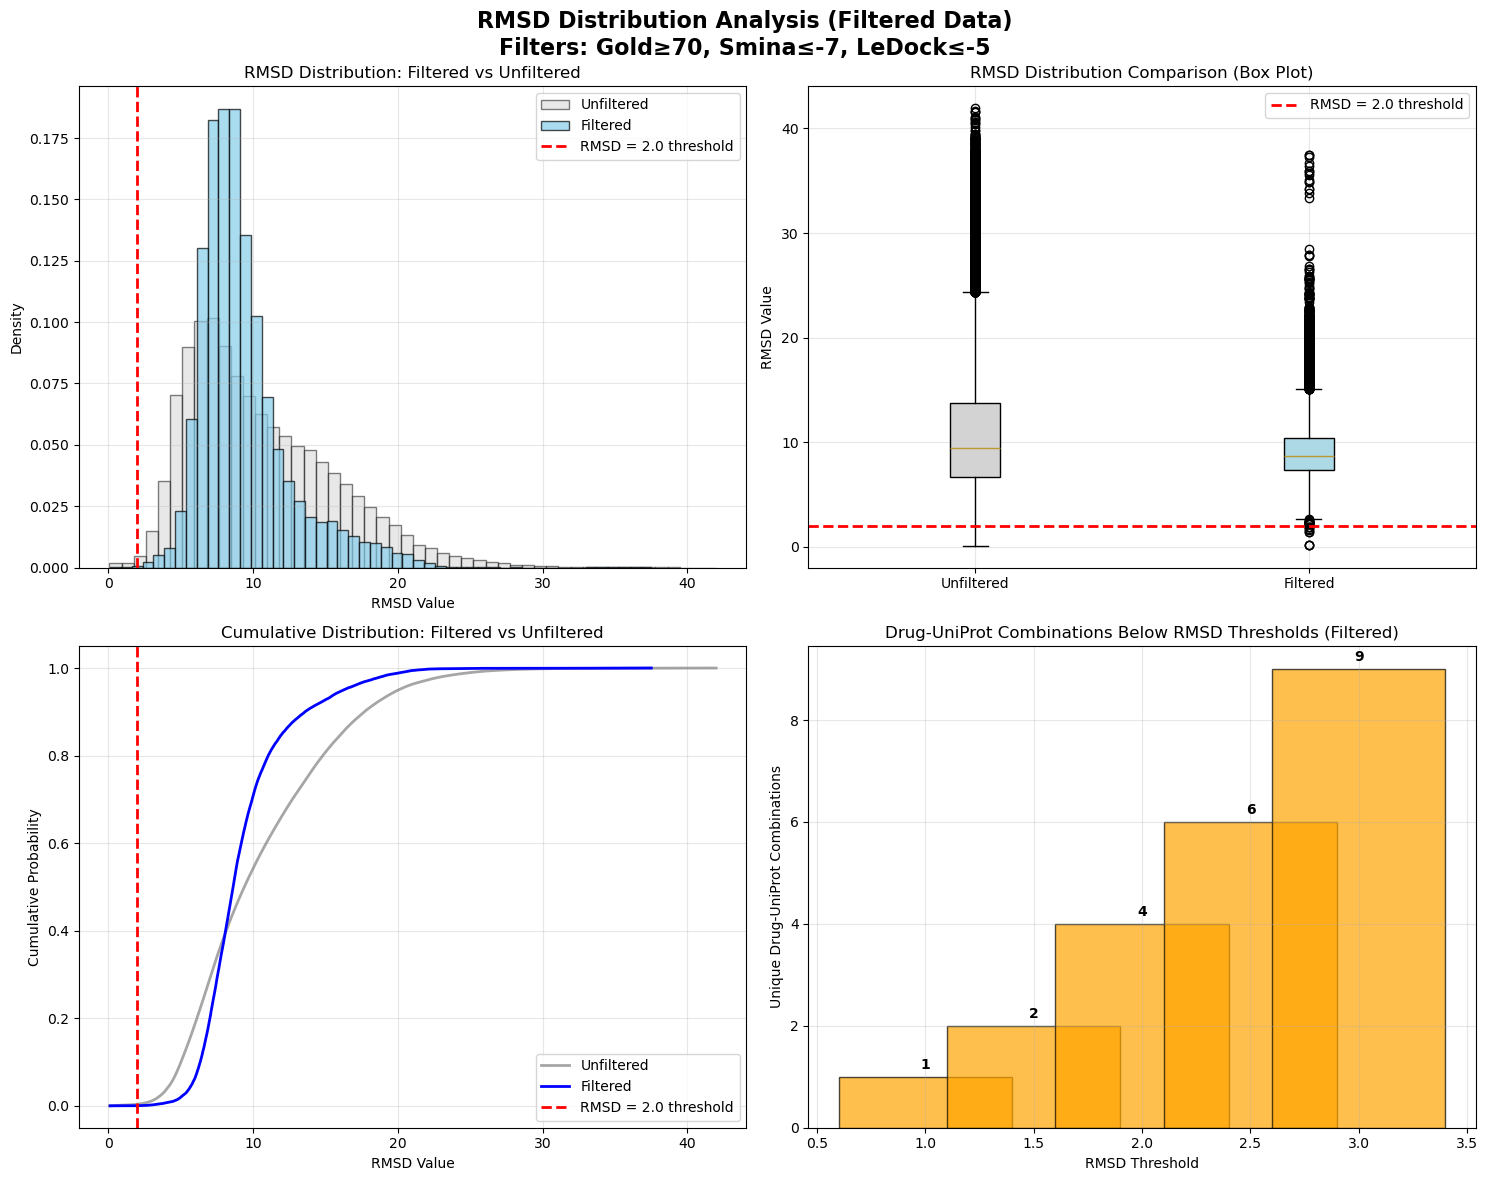


=== RMSD STATISTICS COMPARISON ===
Metric               Unfiltered      Filtered        Change         
-----------------------------------------------------------------
Total values:        1,323,415       35,342          -1,288,073     
Mean RMSD:           10.546          9.363           -1.183         
Median RMSD:         9.405           8.632           -0.773         
Min RMSD:            0.097           0.144           0.046          
Max RMSD:            41.977          37.502          -4.475         
% below 2.0:         0.4             0.0             -0.3           
Median RMSD:         9.405           8.632           -0.773         
Min RMSD:            0.097           0.144           0.046          
Max RMSD:            41.977          37.502          -4.475         
% below 2.0:         0.4             0.0             -0.3           


In [ ]:
# RMSD Distribution Plots (with scoring cutoffs)

if not combined_data.is_empty() and rmsd_columns and 'filtered_data' in globals():
    rmsd_col = rmsd_columns[0]
    
    # Convert filtered data to pandas for easier plotting
    rmsd_values_filtered = filtered_data.select([rmsd_col]).to_pandas()[rmsd_col]
    rmsd_values_unfiltered = combined_data.select([rmsd_col]).to_pandas()[rmsd_col]
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'RMSD Distribution Analysis (Filtered Data)\nFilters: Gold≥{GOLD_MIN_SCORE}, Smina≤{SMINA_MAX_SCORE}, LeDock≤{LEDOCK_MAX_SCORE}', 
                 fontsize=16, fontweight='bold')
    
    # 1. Histogram comparison (filtered vs unfiltered)
    axes[0, 0].hist(rmsd_values_unfiltered, bins=50, alpha=0.5, color='lightgray', 
                    edgecolor='black', label='Unfiltered', density=True)
    axes[0, 0].hist(rmsd_values_filtered, bins=50, alpha=0.7, color='skyblue', 
                    edgecolor='black', label='Filtered', density=True)
    axes[0, 0].axvline(x=2.0, color='red', linestyle='--', linewidth=2, label='RMSD = 2.0 threshold')
    axes[0, 0].set_xlabel('RMSD Value')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('RMSD Distribution: Filtered vs Unfiltered')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Box plot comparison
    box_data = [rmsd_values_unfiltered, rmsd_values_filtered]
    box_labels = ['Unfiltered', 'Filtered']
    bp = axes[0, 1].boxplot(box_data, labels=box_labels, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightgray')
    bp['boxes'][1].set_facecolor('lightblue')
    axes[0, 1].axhline(y=2.0, color='red', linestyle='--', linewidth=2, label='RMSD = 2.0 threshold')
    axes[0, 1].set_ylabel('RMSD Value')
    axes[0, 1].set_title('RMSD Distribution Comparison (Box Plot)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Cumulative distribution comparison
    sorted_rmsd_unfiltered = np.sort(rmsd_values_unfiltered)
    cumulative_unfiltered = np.arange(1, len(sorted_rmsd_unfiltered) + 1) / len(sorted_rmsd_unfiltered)
    sorted_rmsd_filtered = np.sort(rmsd_values_filtered)
    cumulative_filtered = np.arange(1, len(sorted_rmsd_filtered) + 1) / len(sorted_rmsd_filtered)
    
    axes[1, 0].plot(sorted_rmsd_unfiltered, cumulative_unfiltered, linewidth=2, 
                    color='gray', alpha=0.7, label='Unfiltered')
    axes[1, 0].plot(sorted_rmsd_filtered, cumulative_filtered, linewidth=2, 
                    color='blue', label='Filtered')
    axes[1, 0].axvline(x=2.0, color='red', linestyle='--', linewidth=2, label='RMSD = 2.0 threshold')
    axes[1, 0].set_xlabel('RMSD Value')
    axes[1, 0].set_ylabel('Cumulative Probability')
    axes[1, 0].set_title('Cumulative Distribution: Filtered vs Unfiltered')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Threshold analysis bar chart (filtered data)
    thresholds = [1.0, 1.5, 2.0, 2.5, 3.0]
    unique_combinations = []
    
    for threshold in thresholds:
        # Count unique combinations below threshold
        unique_below = analysis_data.filter(pl.col(rmsd_col) < threshold).select(['drugbank_id', 'uniprot_id']).unique().height
        unique_combinations.append(unique_below)
    
    bars = axes[1, 1].bar(thresholds, unique_combinations, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 1].set_xlabel('RMSD Threshold')
    axes[1, 1].set_ylabel('Unique Drug-UniProt Combinations')
    axes[1, 1].set_title('Drug-UniProt Combinations Below RMSD Thresholds (Filtered)')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, unique_combinations):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(unique_combinations)*0.01,
                        f'{value:,}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics comparison
    print(f"\n=== RMSD STATISTICS COMPARISON ===")
    print(f"{'Metric':<20} {'Unfiltered':<15} {'Filtered':<15} {'Change':<15}")
    print("-" * 65)
    print(f"{'Total values:':<20} {len(rmsd_values_unfiltered):<15,} {len(rmsd_values_filtered):<15,} {len(rmsd_values_filtered) - len(rmsd_values_unfiltered):<15,}")
    print(f"{'Mean RMSD:':<20} {rmsd_values_unfiltered.mean():<15.3f} {rmsd_values_filtered.mean():<15.3f} {rmsd_values_filtered.mean() - rmsd_values_unfiltered.mean():<15.3f}")
    print(f"{'Median RMSD:':<20} {rmsd_values_unfiltered.median():<15.3f} {rmsd_values_filtered.median():<15.3f} {rmsd_values_filtered.median() - rmsd_values_unfiltered.median():<15.3f}")
    print(f"{'Min RMSD:':<20} {rmsd_values_unfiltered.min():<15.3f} {rmsd_values_filtered.min():<15.3f} {rmsd_values_filtered.min() - rmsd_values_unfiltered.min():<15.3f}")
    print(f"{'Max RMSD:':<20} {rmsd_values_unfiltered.max():<15.3f} {rmsd_values_filtered.max():<15.3f} {rmsd_values_filtered.max() - rmsd_values_unfiltered.max():<15.3f}")
    
    unfiltered_below_2 = (rmsd_values_unfiltered < 2.0).mean() * 100
    filtered_below_2 = (rmsd_values_filtered < 2.0).mean() * 100
    print(f"{'% below 2.0:':<20} {unfiltered_below_2:<15.1f} {filtered_below_2:<15.1f} {filtered_below_2 - unfiltered_below_2:<15.1f}")
    
elif not combined_data.is_empty() and rmsd_columns:
    print("Warning: Filtered data not available. Please run the cell with scoring cutoffs first.")
else:
    print("No RMSD data available for plotting.")

In [ ]:
# Drug and Gene Performance Analysis Plots (with scoring cutoffs)

if not combined_data.is_empty() and rmsd_columns and 'filtered_data' in globals():
    rmsd_col = rmsd_columns[0]
    
    # Convert filtered data to pandas for easier plotting
    plot_data = filtered_data.to_pandas()
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Drug and Gene Performance Analysis (Filtered Data)\nFilters: Gold≥{GOLD_MIN_SCORE}, Smina≤{SMINA_MAX_SCORE}, LeDock≤{LEDOCK_MAX_SCORE}', 
                 fontsize=16, fontweight='bold')
    
    # 1. Top 15 best performing drugs (by minimum RMSD) - filtered data
    drug_performance = plot_data.groupby('drugbank_id')[rmsd_col].agg(['min', 'mean', 'count']).reset_index()
    drug_performance = drug_performance.sort_values('min').head(15)
    
    bars1 = axes[0, 0].bar(range(len(drug_performance)), drug_performance['min'], 
                           alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 0].axhline(y=2.0, color='red', linestyle='--', linewidth=2, label='RMSD = 2.0 threshold')
    axes[0, 0].set_xlabel('DrugBank ID')
    axes[0, 0].set_ylabel('Best RMSD')
    axes[0, 0].set_title('Top 15 Best Performing Drugs (Lowest RMSD, Filtered)')
    axes[0, 0].set_xticks(range(len(drug_performance)))
    axes[0, 0].set_xticklabels(drug_performance['drugbank_id'], rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Top 15 best performing genes (by minimum RMSD) - filtered data
    gene_performance = plot_data.groupby('gene_name')[rmsd_col].agg(['min', 'mean', 'count']).reset_index()
    gene_performance = gene_performance.sort_values('min').head(15)
    
    bars2 = axes[0, 1].bar(range(len(gene_performance)), gene_performance['min'], 
                           alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].axhline(y=2.0, color='red', linestyle='--', linewidth=2, label='RMSD = 2.0 threshold')
    axes[0, 1].set_xlabel('Gene Name')
    axes[0, 1].set_ylabel('Best RMSD')
    axes[0, 1].set_title('Top 15 Best Performing Genes (Lowest RMSD, Filtered)')
    axes[0, 1].set_xticks(range(len(gene_performance)))
    axes[0, 1].set_xticklabels(gene_performance['gene_name'], rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Success rate by cavity index - filtered data
    cavity_success = plot_data.groupby('cavity_index').apply(
        lambda x: pd.Series({
            'total_combinations': len(x[['drugbank_id', 'uniprot_id']].drop_duplicates()),
            'good_combinations': len(x[x[rmsd_col] < 2.0][['drugbank_id', 'uniprot_id']].drop_duplicates()),
            'success_rate': len(x[x[rmsd_col] < 2.0][['drugbank_id', 'uniprot_id']].drop_duplicates()) / len(x[['drugbank_id', 'uniprot_id']].drop_duplicates()) * 100 if len(x[['drugbank_id', 'uniprot_id']].drop_duplicates()) > 0 else 0
        })
    ).reset_index()
    
    bars3 = axes[1, 0].bar(cavity_success['cavity_index'], cavity_success['success_rate'], 
                           alpha=0.7, color='gold', edgecolor='black')
    axes[1, 0].set_xlabel('Cavity Index')
    axes[1, 0].set_ylabel('Success Rate (%)')
    axes[1, 0].set_title('Success Rate by Cavity Index (% with RMSD < 2.0, Filtered)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars3, cavity_success['success_rate']):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                        f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 4. RMSD distribution by cavity index (violin plot) - filtered data
    cavity_indices = sorted(plot_data['cavity_index'].unique())
    cavity_data = [plot_data[plot_data['cavity_index'] == i][rmsd_col].values 
                   for i in cavity_indices]
    
    # Only plot cavities that have data
    valid_indices = []
    valid_data = []
    for i, data in enumerate(cavity_data):
        if len(data) > 0:
            valid_indices.append(cavity_indices[i])
            valid_data.append(data)
    
    if valid_data:
        parts = axes[1, 1].violinplot(valid_data, positions=valid_indices, 
                                      showmeans=True, showmedians=True)
        axes[1, 1].axhline(y=2.0, color='red', linestyle='--', linewidth=2, label='RMSD = 2.0 threshold')
        axes[1, 1].set_xlabel('Cavity Index')
        axes[1, 1].set_ylabel('RMSD Value')
        axes[1, 1].set_title('RMSD Distribution by Cavity Index (Filtered)')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No data available\nafter filtering', 
                        ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=14)
        axes[1, 1].set_title('RMSD Distribution by Cavity Index (Filtered)')
    
    plt.tight_layout()
    plt.show()
    
    # Print additional insights
    print(f"\n=== PERFORMANCE INSIGHTS (FILTERED DATA) ===")
    if len(drug_performance) > 0:
        print(f"Best performing drug: {drug_performance.iloc[0]['drugbank_id']} (RMSD: {drug_performance.iloc[0]['min']:.3f})")
    if len(gene_performance) > 0:
        print(f"Best performing gene: {gene_performance.iloc[0]['gene_name']} (RMSD: {gene_performance.iloc[0]['min']:.3f})")
    if len(cavity_success) > 0 and cavity_success['success_rate'].max() > 0:
        best_cavity_idx = cavity_success.loc[cavity_success['success_rate'].idxmax(), 'cavity_index']
        best_cavity_rate = cavity_success['success_rate'].max()
        print(f"Best cavity index: {best_cavity_idx} ({best_cavity_rate:.1f}% success rate)")
    
    # Compare with unfiltered data
    print(f"\n=== FILTERING IMPACT ON PERFORMANCE ===")
    unfiltered_plot_data = combined_data.to_pandas()
    
    # Drug comparison
    unfiltered_drug_perf = unfiltered_plot_data.groupby('drugbank_id')[rmsd_col].agg(['min']).reset_index()
    filtered_drug_count = len(drug_performance)
    unfiltered_drug_count = len(unfiltered_drug_perf)
    print(f"Drugs with data: {unfiltered_drug_count} -> {filtered_drug_count} (retained {(filtered_drug_count/unfiltered_drug_count)*100:.1f}%)")
    
    # Gene comparison
    unfiltered_gene_perf = unfiltered_plot_data.groupby('gene_name')[rmsd_col].agg(['min']).reset_index()
    filtered_gene_count = len(gene_performance)
    unfiltered_gene_count = len(unfiltered_gene_perf)
    print(f"Genes with data: {unfiltered_gene_count} -> {filtered_gene_count} (retained {(filtered_gene_count/unfiltered_gene_count)*100:.1f}%)")
    
elif not combined_data.is_empty() and rmsd_columns:
    print("Warning: Filtered data not available. Please run the cell with scoring cutoffs first.")
else:
    print("No RMSD data available for plotting.")

In [ ]:
# Advanced RMSD Analysis Plots (with scoring cutoffs)

if not combined_data.is_empty() and rmsd_columns and 'filtered_data' in globals():
    rmsd_col = rmsd_columns[0]
    plot_data = filtered_data.to_pandas()
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Advanced RMSD Analysis (Filtered Data)\nFilters: Gold≥{GOLD_MIN_SCORE}, Smina≤{SMINA_MAX_SCORE}, LeDock≤{LEDOCK_MAX_SCORE}', 
                 fontsize=16, fontweight='bold')
    
    # 1. Success rate heatmap (top drugs vs top genes) - filtered data
    # Get top 20 drugs and genes by number of combinations in filtered data
    top_drugs = plot_data['drugbank_id'].value_counts().head(20).index
    top_genes = plot_data['gene_name'].value_counts().head(20).index
    
    # Create success rate matrix
    success_matrix = []
    for drug in top_drugs:
        drug_row = []
        for gene in top_genes:
            subset = plot_data[(plot_data['drugbank_id'] == drug) & (plot_data['gene_name'] == gene)]
            if len(subset) > 0:
                success_rate = (subset[rmsd_col] < 2.0).mean() * 100
                drug_row.append(success_rate)
            else:
                drug_row.append(np.nan)
        success_matrix.append(drug_row)
    
    success_matrix = np.array(success_matrix)
    
    # Create heatmap
    im1 = axes[0, 0].imshow(success_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
    axes[0, 0].set_title('Success Rate Heatmap (Top Drugs vs Genes, Filtered)')
    axes[0, 0].set_xlabel('Gene Name')
    axes[0, 0].set_ylabel('DrugBank ID')
    
    if len(top_genes) > 0 and len(top_drugs) > 0:
        axes[0, 0].set_xticks(range(len(top_genes)))
        axes[0, 0].set_xticklabels(top_genes, rotation=45, ha='right')
        axes[0, 0].set_yticks(range(len(top_drugs)))
        axes[0, 0].set_yticklabels(top_drugs)
        
        # Add colorbar
        cbar1 = plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
        cbar1.set_label('Success Rate (%)')
    else:
        axes[0, 0].text(0.5, 0.5, 'Insufficient data\nafter filtering', 
                        ha='center', va='center', transform=axes[0, 0].transAxes, fontsize=14)
    
    # 2. Scatter plot: Number of poses vs Best RMSD for each drug-uniprot combination
    if len(plot_data) > 0:
        combination_stats = plot_data.groupby(['drugbank_id', 'uniprot_id']).agg({
            rmsd_col: ['min', 'count']
        }).reset_index()
        combination_stats.columns = ['drugbank_id', 'uniprot_id', 'best_rmsd', 'num_poses']
        
        # Color points based on whether they have good RMSD
        colors = ['green' if rmsd < 2.0 else 'red' for rmsd in combination_stats['best_rmsd']]
        
        scatter = axes[0, 1].scatter(combination_stats['num_poses'], combination_stats['best_rmsd'], 
                                    c=colors, alpha=0.6, s=30)
        axes[0, 1].axhline(y=2.0, color='red', linestyle='--', linewidth=2, label='RMSD = 2.0 threshold')
        axes[0, 1].set_xlabel('Number of Poses')
        axes[0, 1].set_ylabel('Best RMSD')
        axes[0, 1].set_title('Number of Poses vs Best RMSD (Filtered)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'No data available\nafter filtering', 
                        ha='center', va='center', transform=axes[0, 1].transAxes, fontsize=14)
        axes[0, 1].set_title('Number of Poses vs Best RMSD (Filtered)')
    
    # 3. Success rate by number of poses (binned) - filtered data
    if len(plot_data) > 0 and 'combination_stats' in locals():
        pose_bins = [1, 5, 10, 20, 50, 100, float('inf')]
        pose_labels = ['1-4', '5-9', '10-19', '20-49', '50-99', '100+']
        
        binned_success = []
        binned_counts = []
        
        for i, (lower, upper) in enumerate(zip(pose_bins[:-1], pose_bins[1:])):
            if upper == float('inf'):
                mask = combination_stats['num_poses'] >= lower
            else:
                mask = (combination_stats['num_poses'] >= lower) & (combination_stats['num_poses'] < upper)
            
            subset = combination_stats[mask]
            if len(subset) > 0:
                success_rate = (subset['best_rmsd'] < 2.0).mean() * 100
                binned_success.append(success_rate)
                binned_counts.append(len(subset))
            else:
                binned_success.append(0)
                binned_counts.append(0)
        
        bars4 = axes[1, 0].bar(pose_labels, binned_success, alpha=0.7, color='purple', edgecolor='black')
        axes[1, 0].set_xlabel('Number of Poses per Combination')
        axes[1, 0].set_ylabel('Success Rate (%)')
        axes[1, 0].set_title('Success Rate by Number of Poses (Filtered)')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, value, count in zip(bars4, binned_success, binned_counts):
            if count > 0:
                axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                                f'{value:.1f}%\n(n={count})', ha='center', va='bottom', fontsize=8)
    else:
        axes[1, 0].text(0.5, 0.5, 'No data available\nafter filtering', 
                        ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=14)
        axes[1, 0].set_title('Success Rate by Number of Poses (Filtered)')
    
    # 4. Expected vs Actual Success Rate comparison (filtered data)
    if len(plot_data) > 0 and 'combination_stats' in locals():
        # Calculate expected success if poses were random
        overall_success_rate = (plot_data[rmsd_col] < 2.0).mean()
        
        # For combinations with multiple poses, calculate expected vs actual success
        multi_pose_combinations = combination_stats[combination_stats['num_poses'] > 1]
        if len(multi_pose_combinations) > 0:
            # Expected success if poses were independent random draws
            expected_success_rates = []
            pose_counts = []
            
            for n_poses in range(1, 21):  # Up to 20 poses
                expected = (1 - (1 - overall_success_rate) ** n_poses) * 100
                expected_success_rates.append(expected)
                pose_counts.append(n_poses)
            
            axes[1, 1].plot(pose_counts, expected_success_rates, 'b-', linewidth=2, label='Expected (Random)')
            
            # Plot actual success rates for each number of poses
            actual_by_poses = []
            for n_poses in range(1, 21):
                subset = combination_stats[combination_stats['num_poses'] == n_poses]
                if len(subset) >= 3:  # Only plot if we have at least 3 combinations
                    actual_rate = (subset['best_rmsd'] < 2.0).mean() * 100
                    actual_by_poses.append(actual_rate)
                else:
                    actual_by_poses.append(np.nan)
            
            axes[1, 1].plot(pose_counts, actual_by_poses, 'ro-', linewidth=2, label='Actual')
            axes[1, 1].set_xlabel('Number of Poses per Combination')
            axes[1, 1].set_ylabel('Success Rate (%)')
            axes[1, 1].set_title('Expected vs Actual Success Rate (Filtered)')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'Insufficient multi-pose\ncombinations after filtering', 
                            ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=14)
            axes[1, 1].set_title('Expected vs Actual Success Rate (Filtered)')
    else:
        axes[1, 1].text(0.5, 0.5, 'No data available\nafter filtering', 
                        ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=14)
        axes[1, 1].set_title('Expected vs Actual Success Rate (Filtered)')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    if len(plot_data) > 0 and 'combination_stats' in locals():
        combinations_with_good_poses = (combination_stats['best_rmsd'] < 2.0).sum()
        total_combinations = len(combination_stats)
        
        print(f"\n=== COMBINATION ANALYSIS SUMMARY (FILTERED DATA) ===")
        print(f"Total drug-uniprot combinations: {total_combinations:,}")
        print(f"Combinations with good RMSD (< 2.0): {combinations_with_good_poses:,}")
        if total_combinations > 0:
            print(f"Overall combination success rate: {(combinations_with_good_poses / total_combinations) * 100:.1f}%")
            print(f"Average poses per combination: {combination_stats['num_poses'].mean():.1f}")
            print(f"Median poses per combination: {combination_stats['num_poses'].median():.1f}")
        
        # Compare with unfiltered data
        unfiltered_plot_data = combined_data.to_pandas()
        unfiltered_combination_stats = unfiltered_plot_data.groupby(['drugbank_id', 'uniprot_id']).agg({
            rmsd_col: ['min', 'count']
        }).reset_index()
        unfiltered_combination_stats.columns = ['drugbank_id', 'uniprot_id', 'best_rmsd', 'num_poses']
        
        unfiltered_good = (unfiltered_combination_stats['best_rmsd'] < 2.0).sum()
        unfiltered_total = len(unfiltered_combination_stats)
        
        print(f"\n=== FILTERING IMPACT ON COMBINATIONS ===")
        print(f"Total combinations: {unfiltered_total:,} -> {total_combinations:,}")
        print(f"Good combinations: {unfiltered_good:,} -> {combinations_with_good_poses:,}")
        if unfiltered_total > 0:
            print(f"Success rate: {(unfiltered_good/unfiltered_total)*100:.1f}% -> {(combinations_with_good_poses/total_combinations)*100:.1f}%")
    else:
        print("\n=== COMBINATION ANALYSIS SUMMARY ===")
        print("No data available after applying scoring filters.")
        print("Consider relaxing the cutoff values to retain more data.")
    
elif not combined_data.is_empty() and rmsd_columns:
    print("Warning: Filtered data not available. Please run the cell with scoring cutoffs first.")
else:
    print("No RMSD data available for plotting.")

=== SCORE DISTRIBUTIONS ANALYSIS ===
Processing Tool1/Score1 data...
Processing Tool1/Score1 data...
  GOLD (Tool1): 2,032 unique drug-uniprot combinations
  LEDOCK (Tool1): 10 unique drug-uniprot combinations
Processing Tool2/Score2 data...
  GOLD (Tool1): 2,032 unique drug-uniprot combinations
  LEDOCK (Tool1): 10 unique drug-uniprot combinations
Processing Tool2/Score2 data...
  GOLD (Tool2): 7 unique drug-uniprot combinations
  GOLD (Tool2): 7 unique drug-uniprot combinations
  SMINA (Tool2): 2,035 unique drug-uniprot combinations

Generating score distribution plots...
  SMINA (Tool2): 2,035 unique drug-uniprot combinations

Generating score distribution plots...


/tmp/ipykernel_1174119/384752472.py:174: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(box_data, labels=box_labels, patch_artist=True)


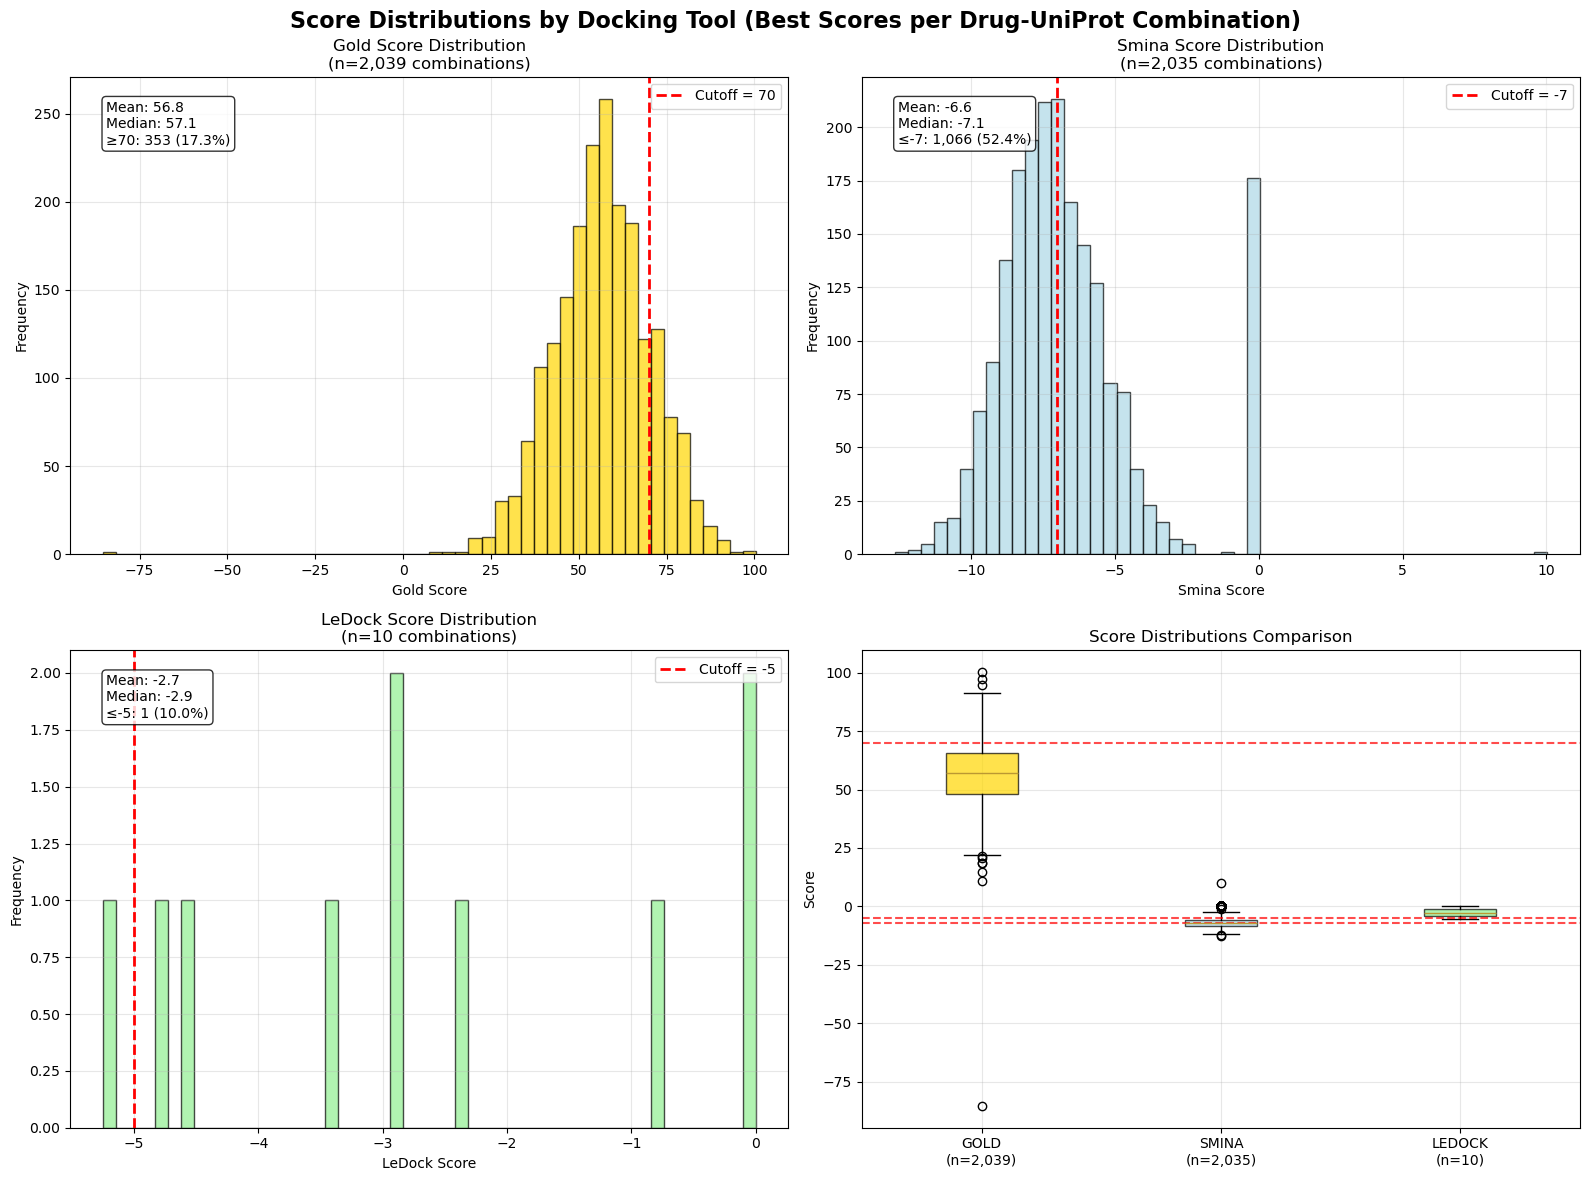


=== SCORE DISTRIBUTION SUMMARY ===

GOLD:
  Unique combinations: 2,039
  Mean score: 56.801
  Median score: 57.070
  Min score: -85.460
  Max score: 100.360
  Std deviation: 13.799
  Above cutoff (≥70): 353 (17.3%)

SMINA:
  Unique combinations: 2,035
  Mean score: -6.600
  Median score: -7.109
  Min score: -12.662
  Max score: 10.032
  Std deviation: 2.583
  Below cutoff (≤-7): 1,066 (52.4%)

LEDOCK:
  Unique combinations: 10
  Mean score: -2.697
  Median score: -2.875
  Min score: -5.250
  Max score: 0.000
  Std deviation: 1.821
  Below cutoff (≤-5): 1 (10.0%)


In [17]:
# Score Distributions Analysis (Best Scores per Drug-UniProt Combination)

if not combined_data.is_empty():
    print("=== SCORE DISTRIBUTIONS ANALYSIS ===")
    
    # Check if we have Tool and Score columns
    has_tool1 = 'Tool1' in combined_data.columns
    has_tool2 = 'Tool2' in combined_data.columns
    has_score1 = 'Score1' in combined_data.columns
    has_score2 = 'Score2' in combined_data.columns
    
    if (has_tool1 and has_score1) or (has_tool2 and has_score2):
        # Create figure for score distributions
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Score Distributions by Docking Tool (Best Scores per Drug-UniProt Combination)', 
                     fontsize=16, fontweight='bold')
        
        tool_data = {}
        
        # Process Tool1/Score1 data
        if has_tool1 and has_score1:
            print("Processing Tool1/Score1 data...")
            
            # Get best scores for each drug-uniprot combination by tool
            for tool_name in ['GOLD', 'SMINA', 'LEDOCK']:
                tool_subset = combined_data.filter(
                    pl.col('Tool1').str.to_uppercase().str.contains(tool_name)
                )
                
                if tool_subset.height > 0:
                    if tool_name == 'GOLD':
                        # For Gold, best = maximum score
                        best_scores = tool_subset.group_by(['drugbank_id', 'uniprot_id']).agg(
                            pl.col('Score1').max().alias('best_score')
                        )
                    else:
                        # For Smina and LeDock, best = minimum score
                        best_scores = tool_subset.group_by(['drugbank_id', 'uniprot_id']).agg(
                            pl.col('Score1').min().alias('best_score')
                        )
                    
                    if best_scores.height > 0:
                        scores = best_scores.select('best_score').to_pandas()['best_score'].values
                        tool_data[f'{tool_name}_Tool1'] = scores
                        print(f"  {tool_name} (Tool1): {len(scores):,} unique drug-uniprot combinations")
        
        # Process Tool2/Score2 data
        if has_tool2 and has_score2:
            print("Processing Tool2/Score2 data...")
            
            # Get best scores for each drug-uniprot combination by tool
            for tool_name in ['GOLD', 'SMINA', 'LEDOCK']:
                tool_subset = combined_data.filter(
                    pl.col('Tool2').str.to_uppercase().str.contains(tool_name)
                )
                
                if tool_subset.height > 0:
                    if tool_name == 'GOLD':
                        # For Gold, best = maximum score
                        best_scores = tool_subset.group_by(['drugbank_id', 'uniprot_id']).agg(
                            pl.col('Score2').max().alias('best_score')
                        )
                    else:
                        # For Smina and LeDock, best = minimum score
                        best_scores = tool_subset.group_by(['drugbank_id', 'uniprot_id']).agg(
                            pl.col('Score2').min().alias('best_score')
                        )
                    
                    if best_scores.height > 0:
                        scores = best_scores.select('best_score').to_pandas()['best_score'].values
                        tool_data[f'{tool_name}_Tool2'] = scores
                        print(f"  {tool_name} (Tool2): {len(scores):,} unique drug-uniprot combinations")
        
        # Plot distributions
        if tool_data:
            print(f"\nGenerating score distribution plots...")
            
            # Combine Tool1 and Tool2 data for each tool type
            combined_tool_data = {}
            for tool_name in ['GOLD', 'SMINA', 'LEDOCK']:
                all_scores = []
                if f'{tool_name}_Tool1' in tool_data:
                    all_scores.extend(tool_data[f'{tool_name}_Tool1'])
                if f'{tool_name}_Tool2' in tool_data:
                    all_scores.extend(tool_data[f'{tool_name}_Tool2'])
                
                if all_scores:
                    combined_tool_data[tool_name] = np.array(all_scores)
            
            # Plot 1: Gold score distribution
            if 'GOLD' in combined_tool_data:
                gold_scores = combined_tool_data['GOLD']
                axes[0, 0].hist(gold_scores, bins=50, alpha=0.7, color='gold', edgecolor='black')
                axes[0, 0].axvline(x=GOLD_MIN_SCORE, color='red', linestyle='--', linewidth=2, 
                                  label=f'Cutoff = {GOLD_MIN_SCORE}')
                axes[0, 0].set_xlabel('Gold Score')
                axes[0, 0].set_ylabel('Frequency')
                axes[0, 0].set_title(f'Gold Score Distribution\n(n={len(gold_scores):,} combinations)')
                axes[0, 0].legend()
                axes[0, 0].grid(True, alpha=0.3)
                
                # Add statistics
                mean_score = gold_scores.mean()
                median_score = np.median(gold_scores)
                above_cutoff = (gold_scores >= GOLD_MIN_SCORE).sum()
                axes[0, 0].text(0.05, 0.95, f'Mean: {mean_score:.1f}\nMedian: {median_score:.1f}\n≥{GOLD_MIN_SCORE}: {above_cutoff:,} ({above_cutoff/len(gold_scores)*100:.1f}%)', 
                               transform=axes[0, 0].transAxes, verticalalignment='top', 
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            else:
                axes[0, 0].text(0.5, 0.5, 'No Gold data available', ha='center', va='center', 
                               transform=axes[0, 0].transAxes, fontsize=14)
                axes[0, 0].set_title('Gold Score Distribution')
            
            # Plot 2: Smina score distribution  
            if 'SMINA' in combined_tool_data:
                smina_scores = combined_tool_data['SMINA']
                axes[0, 1].hist(smina_scores, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
                axes[0, 1].axvline(x=SMINA_MAX_SCORE, color='red', linestyle='--', linewidth=2, 
                                  label=f'Cutoff = {SMINA_MAX_SCORE}')
                axes[0, 1].set_xlabel('Smina Score')
                axes[0, 1].set_ylabel('Frequency')
                axes[0, 1].set_title(f'Smina Score Distribution\n(n={len(smina_scores):,} combinations)')
                axes[0, 1].legend()
                axes[0, 1].grid(True, alpha=0.3)
                
                # Add statistics
                mean_score = smina_scores.mean()
                median_score = np.median(smina_scores)
                below_cutoff = (smina_scores <= SMINA_MAX_SCORE).sum()
                axes[0, 1].text(0.05, 0.95, f'Mean: {mean_score:.1f}\nMedian: {median_score:.1f}\n≤{SMINA_MAX_SCORE}: {below_cutoff:,} ({below_cutoff/len(smina_scores)*100:.1f}%)', 
                               transform=axes[0, 1].transAxes, verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            else:
                axes[0, 1].text(0.5, 0.5, 'No Smina data available', ha='center', va='center', 
                               transform=axes[0, 1].transAxes, fontsize=14)
                axes[0, 1].set_title('Smina Score Distribution')
            
            # Plot 3: LeDock score distribution
            if 'LEDOCK' in combined_tool_data:
                ledock_scores = combined_tool_data['LEDOCK']
                axes[1, 0].hist(ledock_scores, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
                axes[1, 0].axvline(x=LEDOCK_MAX_SCORE, color='red', linestyle='--', linewidth=2, 
                                  label=f'Cutoff = {LEDOCK_MAX_SCORE}')
                axes[1, 0].set_xlabel('LeDock Score')
                axes[1, 0].set_ylabel('Frequency')
                axes[1, 0].set_title(f'LeDock Score Distribution\n(n={len(ledock_scores):,} combinations)')
                axes[1, 0].legend()
                axes[1, 0].grid(True, alpha=0.3)
                
                # Add statistics
                mean_score = ledock_scores.mean()
                median_score = np.median(ledock_scores)
                below_cutoff = (ledock_scores <= LEDOCK_MAX_SCORE).sum()
                axes[1, 0].text(0.05, 0.95, f'Mean: {mean_score:.1f}\nMedian: {median_score:.1f}\n≤{LEDOCK_MAX_SCORE}: {below_cutoff:,} ({below_cutoff/len(ledock_scores)*100:.1f}%)', 
                               transform=axes[1, 0].transAxes, verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            else:
                axes[1, 0].text(0.5, 0.5, 'No LeDock data available', ha='center', va='center', 
                               transform=axes[1, 0].transAxes, fontsize=14)
                axes[1, 0].set_title('LeDock Score Distribution')
            
            # Plot 4: Combined box plot
            box_data = []
            box_labels = []
            colors = []
            
            for tool_name, color in [('GOLD', 'gold'), ('SMINA', 'lightblue'), ('LEDOCK', 'lightgreen')]:
                if tool_name in combined_tool_data:
                    box_data.append(combined_tool_data[tool_name])
                    box_labels.append(f'{tool_name}\n(n={len(combined_tool_data[tool_name]):,})')
                    colors.append(color)
            
            if box_data:
                bp = axes[1, 1].boxplot(box_data, labels=box_labels, patch_artist=True)
                
                # Color the boxes
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
                
                # Add cutoff lines
                if 'GOLD' in combined_tool_data:
                    axes[1, 1].axhline(y=GOLD_MIN_SCORE, color='red', linestyle='--', alpha=0.7)
                if 'SMINA' in combined_tool_data:
                    axes[1, 1].axhline(y=SMINA_MAX_SCORE, color='red', linestyle='--', alpha=0.7)
                if 'LEDOCK' in combined_tool_data:
                    axes[1, 1].axhline(y=LEDOCK_MAX_SCORE, color='red', linestyle='--', alpha=0.7)
                
                axes[1, 1].set_ylabel('Score')
                axes[1, 1].set_title('Score Distributions Comparison')
                axes[1, 1].grid(True, alpha=0.3)
            else:
                axes[1, 1].text(0.5, 0.5, 'No scoring data available', ha='center', va='center', 
                               transform=axes[1, 1].transAxes, fontsize=14)
                axes[1, 1].set_title('Score Distributions Comparison')
            
            plt.tight_layout()
            plt.show()
            
            # Print summary statistics
            print(f"\n=== SCORE DISTRIBUTION SUMMARY ===")
            for tool_name in ['GOLD', 'SMINA', 'LEDOCK']:
                if tool_name in combined_tool_data:
                    scores = combined_tool_data[tool_name]
                    print(f"\n{tool_name}:")
                    print(f"  Unique combinations: {len(scores):,}")
                    print(f"  Mean score: {scores.mean():.3f}")
                    print(f"  Median score: {np.median(scores):.3f}")
                    print(f"  Min score: {scores.min():.3f}")
                    print(f"  Max score: {scores.max():.3f}")
                    print(f"  Std deviation: {scores.std():.3f}")
                    
                    if tool_name == 'GOLD':
                        above_cutoff = (scores >= GOLD_MIN_SCORE).sum()
                        print(f"  Above cutoff (≥{GOLD_MIN_SCORE}): {above_cutoff:,} ({above_cutoff/len(scores)*100:.1f}%)")
                    else:
                        cutoff = SMINA_MAX_SCORE if tool_name == 'SMINA' else LEDOCK_MAX_SCORE
                        below_cutoff = (scores <= cutoff).sum()
                        print(f"  Below cutoff (≤{cutoff}): {below_cutoff:,} ({below_cutoff/len(scores)*100:.1f}%)")
        
        else:
            print("No tool/score data found for distribution analysis.")
    
    else:
        print("No Tool/Score columns found in the dataset.")

else:
    print("No data available for score distribution analysis.")

=== TOOL COVERAGE ANALYSIS ===
Processing Tool1/Score1 data...
Processing Tool2/Score2 data...
Processing Tool2/Score2 data...

=== TOOL COVERAGE RESULTS ===
Individual tool coverage:
  GOLD: 2,032 unique drug-uniprot combinations
  SMINA: 2,035 unique drug-uniprot combinations
  LEDOCK: 10 unique drug-uniprot combinations

Combinations with ALL three tools (Gold AND Smina AND LeDock): 7
Combinations with ANY tool (Gold OR Smina OR LeDock): 2,035

Pairwise overlaps:
  Gold AND Smina: 2,032
  Gold AND LeDock: 7
  Smina AND LeDock: 10

Tool-specific combinations (only one tool):
  Only Gold: 0
  Only Smina: 0
  Only LeDock: 0

=== TOOL COVERAGE RESULTS ===
Individual tool coverage:
  GOLD: 2,032 unique drug-uniprot combinations
  SMINA: 2,035 unique drug-uniprot combinations
  LEDOCK: 10 unique drug-uniprot combinations

Combinations with ALL three tools (Gold AND Smina AND LeDock): 7
Combinations with ANY tool (Gold OR Smina OR LeDock): 2,035

Pairwise overlaps:
  Gold AND Smina: 2,032


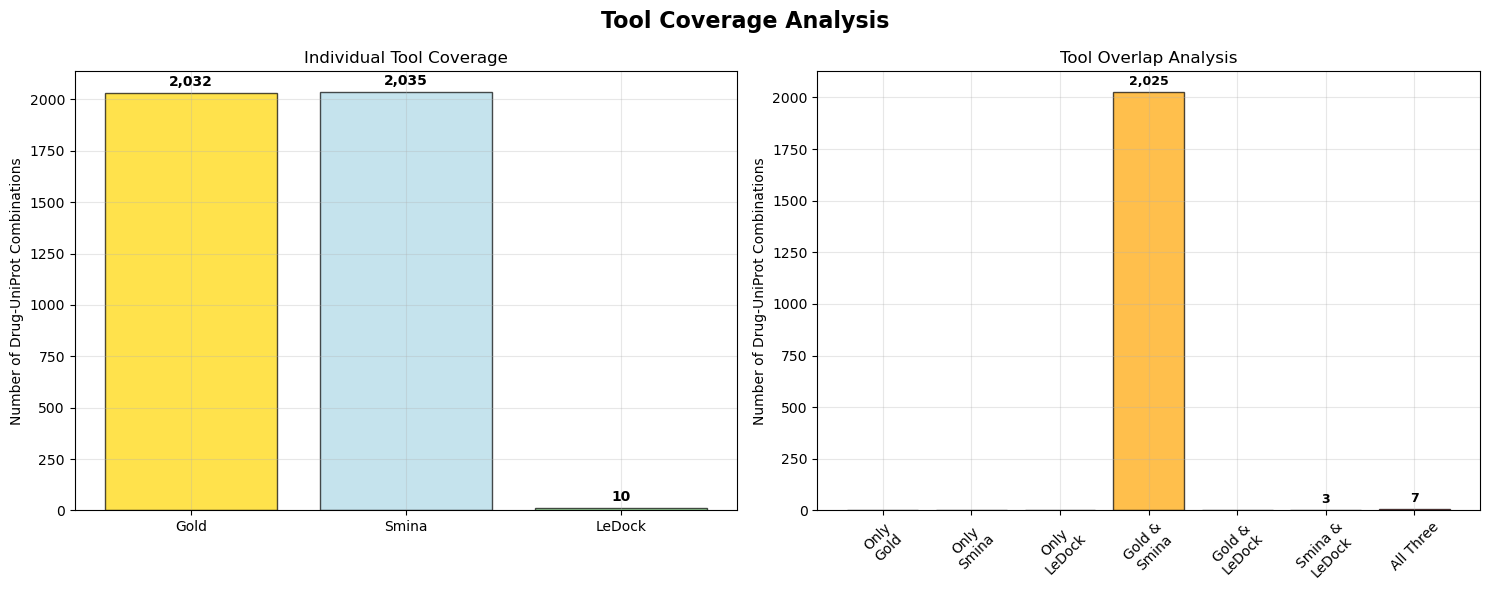


=== COVERAGE PERCENTAGES ===
Total unique drug-uniprot combinations in dataset: 2,035
  GOLD coverage: 99.9%
  SMINA coverage: 100.0%
  LEDOCK coverage: 0.5%
  ANY tool coverage: 100.0%
  ALL tools coverage: 0.3%

=== SUMMARY TABLE ===
Category                  Count      Percentage  
-----------------------------------------------
Total combinations        2,035      100.0%      
Gold only                 2,032      99.9        %
Smina only                2,035      100.0       %
LeDock only               10         0.5         %
Any tool (OR)             2,035      100.0       %
All tools (AND)           7          0.3         %


In [18]:
# Tool Coverage Analysis - Drug-UniProt Combinations by Tool

if not combined_data.is_empty():
    print("=== TOOL COVERAGE ANALYSIS ===")
    
    # Check if we have Tool and Score columns
    has_tool1 = 'Tool1' in combined_data.columns
    has_tool2 = 'Tool2' in combined_data.columns
    has_score1 = 'Score1' in combined_data.columns
    has_score2 = 'Score2' in combined_data.columns
    
    if (has_tool1 and has_score1) or (has_tool2 and has_score2):
        
        # Collect all drug-uniprot combinations for each tool
        tool_combinations = {
            'GOLD': set(),
            'SMINA': set(), 
            'LEDOCK': set()
        }
        
        # Process Tool1/Score1 data
        if has_tool1 and has_score1:
            print("Processing Tool1/Score1 data...")
            
            for tool_name in ['GOLD', 'SMINA', 'LEDOCK']:
                if tool_name == 'LEDOCK':
                    # Check for both LEDOCK and LEDOCK variations
                    tool_subset = combined_data.filter(
                        pl.col('Tool1').str.to_uppercase().str.contains('LEDOCK')
                    )
                else:
                    tool_subset = combined_data.filter(
                        pl.col('Tool1').str.to_uppercase() == tool_name
                    )
                
                if tool_subset.height > 0:
                    combinations = tool_subset.select(['drugbank_id', 'uniprot_id']).unique()
                    for row in combinations.iter_rows():
                        tool_combinations[tool_name].add((row[0], row[1]))
        
        # Process Tool2/Score2 data
        if has_tool2 and has_score2:
            print("Processing Tool2/Score2 data...")
            
            for tool_name in ['GOLD', 'SMINA', 'LEDOCK']:
                if tool_name == 'LEDOCK':
                    # Check for both LEDOCK and LEDOCK variations
                    tool_subset = combined_data.filter(
                        pl.col('Tool2').str.to_uppercase().str.contains('LEDOCK')
                    )
                else:
                    tool_subset = combined_data.filter(
                        pl.col('Tool2').str.to_uppercase() == tool_name
                    )
                
                if tool_subset.height > 0:
                    combinations = tool_subset.select(['drugbank_id', 'uniprot_id']).unique()
                    for row in combinations.iter_rows():
                        tool_combinations[tool_name].add((row[0], row[1]))
        
        # Calculate overlaps and coverage
        print(f"\n=== TOOL COVERAGE RESULTS ===")
        print(f"Individual tool coverage:")
        for tool_name, combinations in tool_combinations.items():
            print(f"  {tool_name}: {len(combinations):,} unique drug-uniprot combinations")
        
        # Calculate combinations with all three tools
        all_tools = tool_combinations['GOLD'] & tool_combinations['SMINA'] & tool_combinations['LEDOCK']
        print(f"\nCombinations with ALL three tools (Gold AND Smina AND LeDock): {len(all_tools):,}")
        
        # Calculate combinations with at least one tool
        any_tool = tool_combinations['GOLD'] | tool_combinations['SMINA'] | tool_combinations['LEDOCK']
        print(f"Combinations with ANY tool (Gold OR Smina OR LeDock): {len(any_tool):,}")
        
        # Calculate pairwise overlaps
        print(f"\nPairwise overlaps:")
        gold_smina = tool_combinations['GOLD'] & tool_combinations['SMINA']
        gold_ledock = tool_combinations['GOLD'] & tool_combinations['LEDOCK']
        smina_ledock = tool_combinations['SMINA'] & tool_combinations['LEDOCK']
        
        print(f"  Gold AND Smina: {len(gold_smina):,}")
        print(f"  Gold AND LeDock: {len(gold_ledock):,}")
        print(f"  Smina AND LeDock: {len(smina_ledock):,}")
        
        # Calculate tool-specific combinations (only one tool)
        print(f"\nTool-specific combinations (only one tool):")
        only_gold = tool_combinations['GOLD'] - tool_combinations['SMINA'] - tool_combinations['LEDOCK']
        only_smina = tool_combinations['SMINA'] - tool_combinations['GOLD'] - tool_combinations['LEDOCK']
        only_ledock = tool_combinations['LEDOCK'] - tool_combinations['GOLD'] - tool_combinations['SMINA']
        
        print(f"  Only Gold: {len(only_gold):,}")
        print(f"  Only Smina: {len(only_smina):,}")
        print(f"  Only LeDock: {len(only_ledock):,}")
        
        # Create a coverage visualization
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle('Tool Coverage Analysis', fontsize=16, fontweight='bold')
        
        # Plot 1: Individual tool coverage
        tools = ['Gold', 'Smina', 'LeDock']
        counts = [len(tool_combinations['GOLD']), len(tool_combinations['SMINA']), len(tool_combinations['LEDOCK'])]
        colors = ['gold', 'lightblue', 'lightgreen']
        
        bars1 = axes[0].bar(tools, counts, color=colors, alpha=0.7, edgecolor='black')
        axes[0].set_ylabel('Number of Drug-UniProt Combinations')
        axes[0].set_title('Individual Tool Coverage')
        axes[0].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, count in zip(bars1, counts):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                        f'{count:,}', ha='center', va='bottom', fontweight='bold')
        
        # Plot 2: Overlap analysis
        overlap_categories = ['Only\nGold', 'Only\nSmina', 'Only\nLeDock', 
                             'Gold &\nSmina', 'Gold &\nLeDock', 'Smina &\nLeDock', 
                             'All Three']
        overlap_counts = [len(only_gold), len(only_smina), len(only_ledock),
                         len(gold_smina) - len(all_tools), 
                         len(gold_ledock) - len(all_tools),
                         len(smina_ledock) - len(all_tools),
                         len(all_tools)]
        overlap_colors = ['gold', 'lightblue', 'lightgreen', 'orange', 'yellow', 'pink', 'red']
        
        bars2 = axes[1].bar(overlap_categories, overlap_counts, color=overlap_colors, alpha=0.7, edgecolor='black')
        axes[1].set_ylabel('Number of Drug-UniProt Combinations')
        axes[1].set_title('Tool Overlap Analysis')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, count in zip(bars2, overlap_counts):
            if count > 0:
                axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(overlap_counts)*0.01,
                            f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate percentages
        total_combinations = combined_data.select(['drugbank_id', 'uniprot_id']).unique().height
        print(f"\n=== COVERAGE PERCENTAGES ===")
        print(f"Total unique drug-uniprot combinations in dataset: {total_combinations:,}")
        
        for tool_name, combinations in tool_combinations.items():
            percentage = (len(combinations) / total_combinations) * 100 if total_combinations > 0 else 0
            print(f"  {tool_name} coverage: {percentage:.1f}%")
        
        any_tool_percentage = (len(any_tool) / total_combinations) * 100 if total_combinations > 0 else 0
        all_tools_percentage = (len(all_tools) / total_combinations) * 100 if total_combinations > 0 else 0
        
        print(f"  ANY tool coverage: {any_tool_percentage:.1f}%")
        print(f"  ALL tools coverage: {all_tools_percentage:.1f}%")
        
        # Summary table
        print(f"\n=== SUMMARY TABLE ===")
        print(f"{'Category':<25} {'Count':<10} {'Percentage':<12}")
        print("-" * 47)
        print(f"{'Total combinations':<25} {total_combinations:<10,} {'100.0%':<12}")
        print(f"{'Gold only':<25} {len(tool_combinations['GOLD']):<10,} {(len(tool_combinations['GOLD'])/total_combinations)*100:<12.1f}%")
        print(f"{'Smina only':<25} {len(tool_combinations['SMINA']):<10,} {(len(tool_combinations['SMINA'])/total_combinations)*100:<12.1f}%")
        print(f"{'LeDock only':<25} {len(tool_combinations['LEDOCK']):<10,} {(len(tool_combinations['LEDOCK'])/total_combinations)*100:<12.1f}%")
        print(f"{'Any tool (OR)':<25} {len(any_tool):<10,} {any_tool_percentage:<12.1f}%")
        print(f"{'All tools (AND)':<25} {len(all_tools):<10,} {all_tools_percentage:<12.1f}%")
        
    else:
        print("No Tool/Score columns found in the dataset.")
        
else:
    print("No data available for tool coverage analysis.")